# ICAPS24 SkDecide Tutorial: Implementing a scikit-decide domain for RDDL problems

In [1]:
!wget https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/main/notebooks/install_skdecide.py

from install_skdecide import install_skdecide
install_skdecide(using_nightly_version=True, force_reinstall=False)

--2024-05-22 18:10:45--  https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/main/notebooks/install_skdecide.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2214 (2,2K) [text/plain]
Saving to: ‘install_skdecide.py.6’

install_skdecide.py 100%[===================>]   2,16K  --.-KB/s    in 0s      

2024-05-22 18:10:45 (117 MB/s) - ‘install_skdecide.py.6’ saved [2214/2214]

Scikit-decide is already installed and we should not forcely reinstall it


In [1]:
!pip install pyRDDLGym pyRDDLGym-rl rddlrepository

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 1.5 MB/s eta 0:00:00a 0:00:01


[Code generator](https://airbus.github.io/scikit-decide/codegen/)

## Without action preconditions

![Domain code generator](pictures/skdecide_code_generators.png)

```python
from enum import Enum
from typing import *

from skdecide import *
from skdecide.builders.domain import *


# Example of State type (adapt to your needs)
class State(NamedTuple):
    x: int
    y: int


# Example of Action type (adapt to your needs)
class Action(Enum):
    up = 0
    down = 1
    left = 2
    right = 3


class D(RLDomain, UnrestrictedActions, FullyObservable, Renderable):
    T_state = State  # Type of states
    T_observation = T_state  # Type of observations
    T_event = Action  # Type of events
    T_value = float  # Type of transition values (rewards or costs)
    T_info = None  # Type of additional information in environment outcome


class MyDomain(D):
    
    def _state_step(self, action: D.T_event) -> TransitionOutcome[D.T_state, Value[D.T_value], D.T_predicate, D.T_info]:
        pass
    
    def _get_action_space_(self) -> Space[D.T_event]:
        pass
    
    def _state_reset(self) -> D.T_state:
        pass
    
    def _get_observation_space_(self) -> Space[D.T_observation]:
        pass

    def _render_from(self, memory: D.T_state, **kwargs: Any) -> Any:
        pass
```

In [1]:
from typing import Iterable, Tuple
from itertools import product
from skdecide.hub.space.gym import DictSpace
from skdecide.core import EnumerableSpace, T


class EnumerableDictSpace(DictSpace, EnumerableSpace[Tuple[str, T]]):
    def get_elements(self) -> Iterable[Tuple[str, T]]:
        prods = product([(k, sp.get_elements()) for k, sp in self._spaces.items()])
        return [{k: e for k, e in p} for p in prods]

In [1]:
from typing import Any

from skdecide.core import TransitionOutcome, Value, Space
from skdecide.domains import RLDomain
from skdecide.builders.domain import UnrestrictedActions, FullyObservable, Renderable
from skdecide.hub.space.gym import DictSpace, GymSpace, MultiDiscreteSpace
from skdecide.utils import rollout

import pyRDDLGym
from pyRDDLGym_rl.core.env import SimplifiedActionRDDLEnv

class D(RLDomain, UnrestrictedActions, FullyObservable, Renderable):
    T_state = DictSpace  # Type of states
    T_observation = T_state  # Type of observations
    T_event = MultiDiscreteSpace  # Type of events
    T_value = float  # Type of transition values (rewards or costs)
    T_info = None  # Type of additional information in environment outcome


class RDDLDomainUnrestrictedActions(D):

    def __init__(self, rddl_domain: str, rddl_instance: str):
        self.rddl_gym_env = pyRDDLGym.make(rddl_domain, rddl_instance, base_class=SimplifiedActionRDDLEnv, enforce_action_constraints=True)

    def _state_step(
        self, action: D.T_event
    ) -> TransitionOutcome[D.T_state, Value[D.T_value], D.T_predicate, D.T_info]:
        next_state, reward, terminated, truncated, _ = self.rddl_gym_env.step(action)
        return TransitionOutcome(
            state=next_state, value=Value(reward=reward), termination=terminated or truncated
        )

    def _get_action_space_(self) -> Space[D.T_event]:
        return GymSpace(self.rddl_gym_env.action_space)

    def _state_reset(self) -> D.T_state:
        # SkDecide only needs the state, not the info
        return self.rddl_gym_env.reset()[0]

    def _get_observation_space_(self) -> Space[D.T_observation]:
        return GymSpace(self.rddl_gym_env.observation_space)

    def _render_from(self, memory: D.T_state = None, **kwargs: Any) -> Any:
        # We do not want the image to be displayed in a pygame window, but rather in this notebook
        return self.rddl_gym_env.render(to_display=False)

In [2]:
from rddlrepository.core.manager import RDDLRepoManager
manager = RDDLRepoManager(rebuild=True)
print(manager.list_problems())

['Traffic', 'Reservoir_Discrete', 'Reservoir_Continuous', 'SupplyChain', 'Elevators', 'Pong', 'UAV_Mixed', 'UAV_Discrete', 'UAV_Continuous', 'Portfolio', 'PowerGen_Discrete', 'PowerGen_Continuous', 'Quadcopter', 'Reservoir_ippc2023', 'RaceCar_ippc2023', 'RecSim_ippc2023', 'HVAC_ippc2023', 'UAV_ippc2023', 'MountainCar_ippc2023', 'PowerGen_ippc2023', 'MarsRover_ippc2023', 'Traffic_MDP_ippc2014', 'Traffic_POMDP_ippc2014', 'CrossingTraffic_MDP_ippc2014', 'CrossingTraffic_POMDP_ippc2014', 'AcademicAdvising_MDP_ippc2014', 'AcademicAdvising_POMDP_ippc2014', 'Tamarisk_MDP_ippc2014', 'Tamarisk_POMDP_ippc2014', 'Wildfire_MDP_ippc2014', 'Wildfire_POMDP_ippc2014', 'Elevators_MDP_ippc2014', 'Elevators_POMDP_ippc2014', 'TriangleTireworld_MDP_ippc2014', 'TriangleTireworld_POMDP_ippc2014', 'SkillTeaching_MDP_ippc2014', 'SkillTeaching_POMDP_ippc2014', 'Manufacturer_ippc2018', 'AcademicAdvising_ippc2018', 'PushYourLuck_ippc2018', 'RedFinnedBlueEye_ippc2018', 'CooperativeRecon_ippc2018', 'EarthObservatio

/Users/teichteil_fl/Projects/SkDecide/skdecide-icaps24-tutorial/.env/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/Users/teichteil_fl/Projects/SkDecide/skdecide-icaps24-tutorial/.env/lib/python3.10/site-packages/pyRDDLGym/core/visualizer/chart.py:193: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self._ax[y].set_ylim([vmin, vmax])


<PIL.Image.Image image mode=RGB size=1000x1000 at 0x126C6EFB0>


(0.0, 20.0, 0.095, 0.10500000000000001)

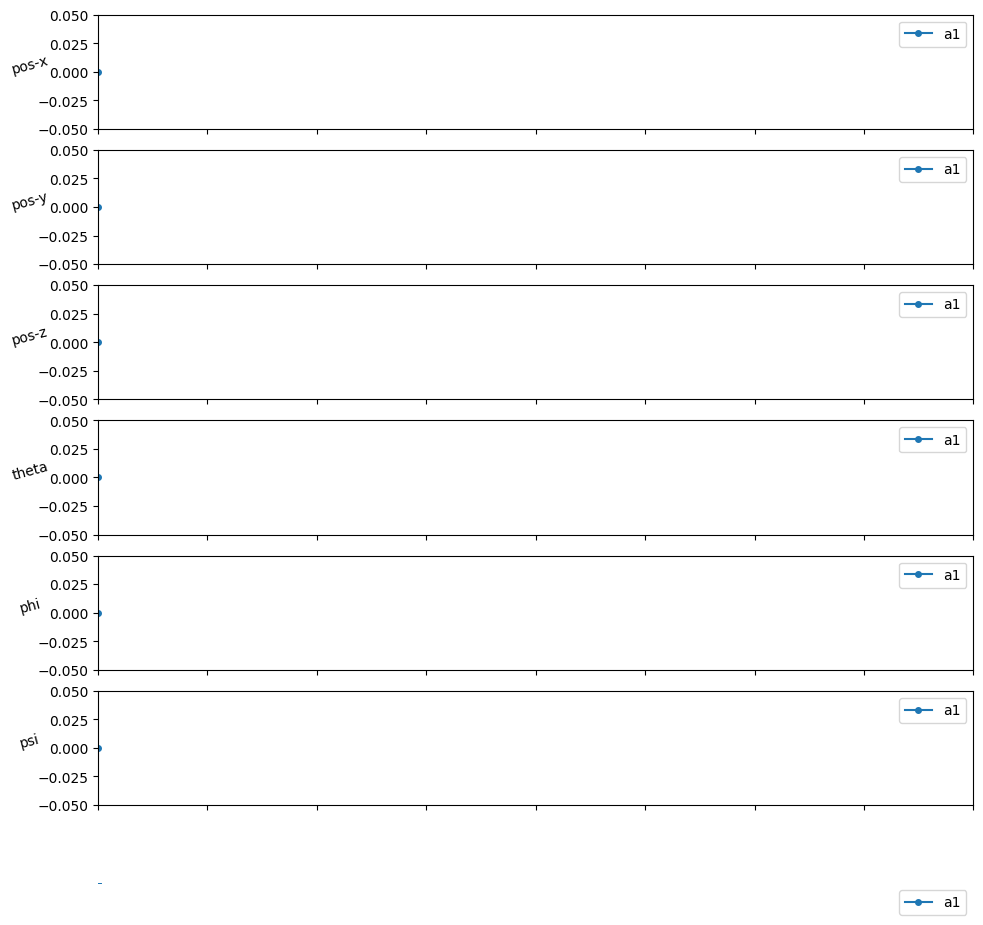

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

problem_info = manager.get_problem("UAV_Discrete")
domain_factory = lambda: RDDLDomainUnrestrictedActions(rddl_domain=problem_info.get_domain(), rddl_instance=problem_info.get_instance(0))
domain = domain_factory()
domain.reset()
r = domain.render()
print(r)
plt.imshow(r)
plt.axis("off")

In [4]:
from skdecide import Solver
from typing import Optional
from time import sleep
from IPython.display import clear_output

def rollout(
    domain: RLDomain,
    solver: Solver,
    max_steps: int,
    pause_between_steps: Optional[float] = 0.01,
    render: bool = True,
):
    """Roll out one episode in a domain according to the policy of a trained solver.

    Args:
        domain: the maze domain to solve
        solver: a trained solver
        max_steps: maximum number of steps allowed to reach the goal
        pause_between_steps: time (s) paused between agent movements.
          No pause if None.
        render: if True, the rollout is rendered in a matplotlib figure as an animation;
            if False, speed up a lot the rollout.

    """
    # Initialize episode
    solver.reset()
    observation = domain.reset()
    termination_reached = False

    # Initialize image
    if render:
        plt.ioff()
        fig, ax = plt.subplots(1)
        ax.axis("off")
        plt.ion()
        img = ax.imshow(domain.render(mode="rgb_array"))
        display(fig)

    # loop until max_steps or goal is reached
    for i_step in range(1, max_steps + 1):
        if pause_between_steps is not None:
            sleep(pause_between_steps)

        # choose action according to solver
        action = solver.sample_action(observation)
        # get corresponding action
        outcome = domain.step(action)
        observation = outcome.observation

        # update image
        if render:
            img.set_data(domain.render())
            fig.canvas.draw()
            clear_output(wait=True)
            display(fig)

        # final state reached?
        if outcome.termination:
            termination_reached = True
            break

    # close the figure to avoid jupyter duplicating the last image
    if render:
        plt.close(fig)

    # terminal (potentially goal) state reached?
    if termination_reached:
        print(f"Terminal observation reached in {i_step} steps!")
    else:
        print(f"Terminal observation not reached after {i_step} steps!")

    return termination_reached, i_step

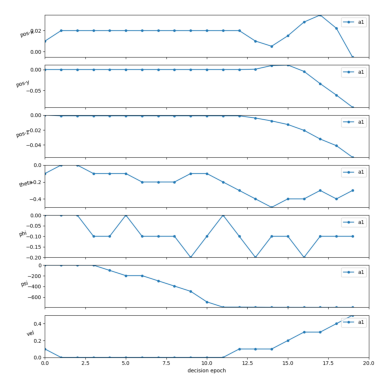

Terminal observation reached in 20 steps!


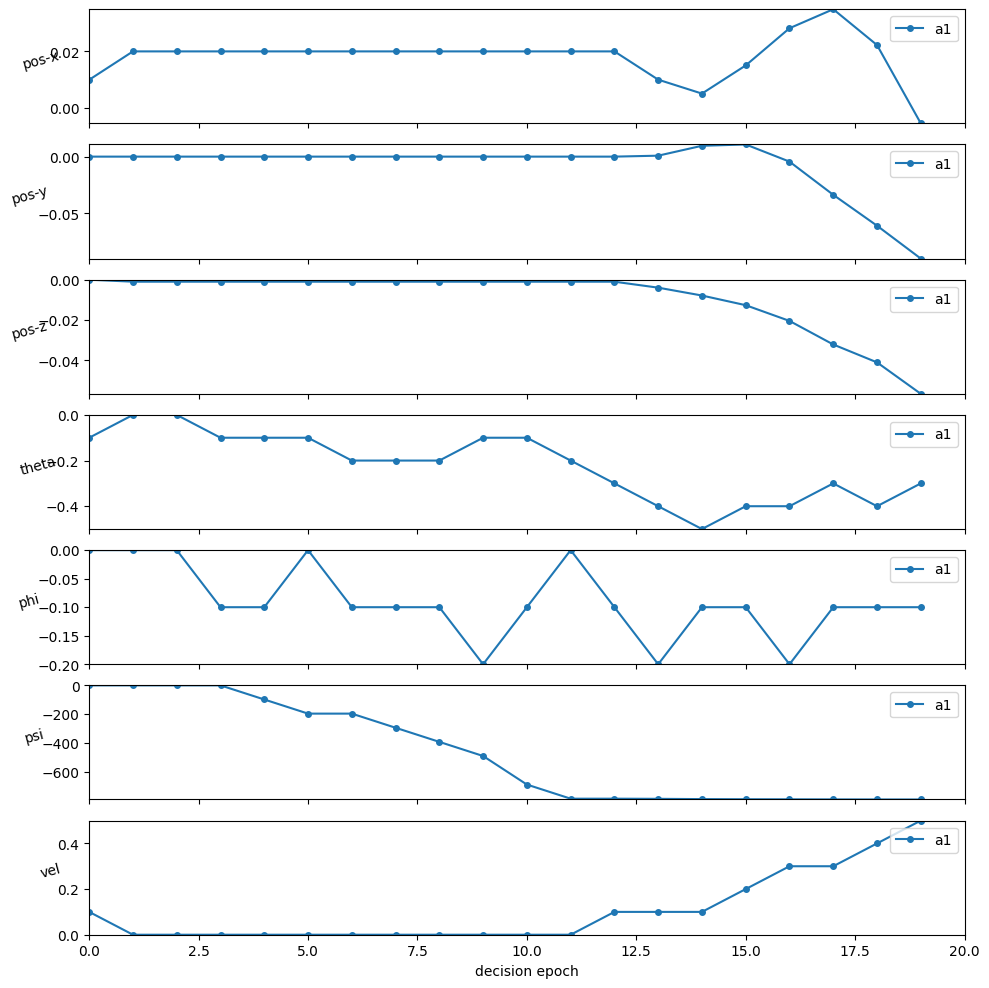

In [55]:
from skdecide.hub.solver.ray_rllib import RayRLlib
from ray.rllib.algorithms.ppo import PPO

solver_factory = lambda: RayRLlib(
    domain_factory=domain_factory, algo_class=PPO, train_iterations=1
)

with solver_factory() as solver:
    solver.solve()
    rollout(
        domain_factory(),
        solver,
        max_steps=100,
    )


In [8]:
from skdecide.hub.solver.mcts import MCTS

solver_factory = lambda: MCTS(
        domain_factory=domain_factory,
        time_budget=10000,
        rollout_budget=1000,
        max_depth=500,
        discount=1.0,
        transition_mode=MCTS.TransitionMode.STEP,
        expander=MCTS.Expander.PARTIAL,
        continuous_planning=False,
        online_node_garbage=True,
        parallel=False,
        verbose=False,
    )
with solver_factory() as solver:
    solver._init_solve()
    rollout(
        domain_factory(),
        solver,
        max_steps=100,
        render=False
    )

NEW STUFF
[2024-05-24 19:43:37.791] [warning] Requesting MCTS random rollout policy but providing custom policy functor (will be ignored)
[2024-05-24 19:43:37.812] [info] Running sequential MCTS solver from state {'pos-x': array([0.]), 'pos-y': array([0.]), 'pos-z': array([0.]), 'theta': array([0.]), 'phi': array([0.]), 'psi': array([0.]), 'vel': array([0.1])}
[2024-05-24 19:43:46.955] [info] MCTS finished to solve from state {'pos-x': array([0.]), 'pos-y': array([0.]), 'pos-z': array([0.]), 'theta': array([0.]), 'phi': array([0.]), 'psi': array([0.]), 'vel': array([0.1])} in 0.009142 seconds with 1000 rollouts.
[2024-05-24 19:43:46.996] [info] Running sequential MCTS solver from state {'pos-x': array([0.01]), 'pos-y': array([0.]), 'pos-z': array([0.]), 'theta': array([0.]), 'phi': array([0.]), 'psi': array([-196.65595729]), 'vel': array([0.])}
[2024-05-24 19:43:56.109] [info] MCTS finished to solve from state {'pos-x': array([0.01]), 'pos-y': array([0.]), 'pos-z': array([0.]), 'theta'

RDDLEpisodeAlreadyEndedError: The step() function has been called even though the current episode has terminated or truncated: please call reset().